In [1]:
import numpy as np
import math
import h5py
import time
import itertools
from tqdm import tqdm
from tqdm import trange
from multiprocessing import Pool, cpu_count

import pandas as pd
import _pickle as cPickle

import matplotlib.pyplot as plt
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Import NN models from file
from NNmodels import DNN_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from keras_tqdm import TQDMNotebookCallback
from keras.models import load_model

from skimage.transform import iradon

from variables_mockup_rep6 import list_tth, list_db, list_icor, list_combination, length_list, dict_ph, n_ph
from functions_mockup_rep6 import MP_intermediate, MP_intermediate_1, MP_intermediate_2, MP_intermediate_3, MP_Pattern_rebuilding, Rwp

2024-03-05 08:50:41.739480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 08:50:41.846694: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 08:50:41.850120: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-05 08:50:41.850132: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Dataset generation (skip if already done)

# =============================================================================
# Main code here (if __name__ == "__main__": enclosing required for 
# proper multiprocessing functioning)
# =============================================================================
if __name__ == "__main__":
    
    sizeTest = 14286 # 14286 for 100K patterns # Number of diagrams per combination
    ## Add the next line, if MP_intermediate_1/2/3 is chosen instead
    # list_combination = [x for x in itertools.combinations(range(3), 1/2/3)] # 3 choose 1/2/3
    # =============================================================================
    #      Starting the dataset creation
    #      Multi processing routine here
    # =============================================================================
    n_processes = cpu_count()
    print("Starting drx pattern generation on "+str(n_processes)+" CPUs")
    
    args = zip(itertools.repeat(list_tth), itertools.repeat(list_db), 
                itertools.repeat(list_icor), itertools.repeat(sizeTest), 
                list_combination)
    
    if 1:
        start = time.time()
        with Pool(processes=n_processes) as proc_pool:
            # Modify MP_intermediate if necessary
            results = proc_pool.starmap(MP_intermediate, tqdm(args, total=len(list_combination)), chunksize=1)
        # =============================================================================
        #     Concatenate the results to form one numpy array
        # =============================================================================
        dataset = np.empty((0, length_list+3*n_ph), float)
        for res in results:
            dataset = np.append(dataset, res, axis=0)

    if 1:    
        # =============================================================================
        #     Save and print
        ## NPY files more than 4GB are difficult to 
        ## save in standard computers, hence using pickle
        # =============================================================================
        with open("datasetRep6_"+str(sizeTest*len(list_combination)//1000)+"K.pickle", "wb") as output_file:
            cPickle.dump([dataset], output_file)
        print("Shape du dataset :", dataset.shape)
        # Print the creation time of the dataset
        end = time.time()
        tps = int(end - start)
        print("Temps : ", tps//60, 'minutes', tps%60, 'secondes')
        # Print the number of error in the dataset
        print("Nombre d'erreur :", np.isnan(dataset).sum())

## Visualization of the data

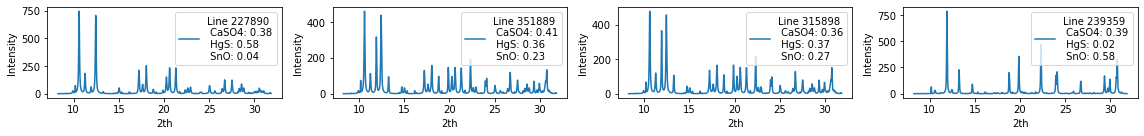

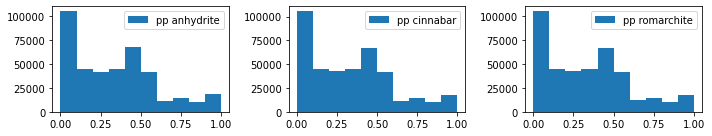

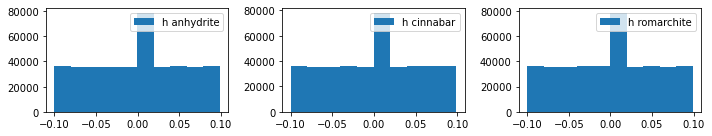

In [2]:
with open("dataset_mockup_rep6.pickle", "rb") as input_file:
    dataset = cPickle.load(input_file)[0]

# Check some patterns to see if everything is ok
fig,axs = plt.subplots(1,4,figsize=(16,2))
for i,ax in enumerate(axs.flatten()):
    ind = np.random.randint(0, dataset.shape[0])
    ax.plot(list_tth, dataset[ind,:len(list_tth)], zorder=2, 
            label=f"Line {ind}\n CaSO4: {np.round(dataset[ind, len(list_tth)], 2)}\n HgS: {np.round(dataset[ind, len(list_tth)+1],2)}\n SnO: {np.round(dataset[ind, len(list_tth)+2],2)}")
    ax.set_ylabel('Intensity')
    ax.set_xlabel('2th')
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Check the phase fraction distribution
fig,axs = plt.subplots(1,3,figsize=(10,2))
for i in range(n_ph):
    axs[i].hist(dataset[:, len(list_tth)+i], bins=10, label=f"pp {dict_ph[i]}")
    axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

# Same for h
fig,axs = plt.subplots(1,3,figsize=(10,2))
for i in range(n_ph):
    axs[i].hist(dataset[:, len(list_tth)+2*n_ph+i], bins=10, label=f"h {dict_ph[i]}")
    axs[i].legend(loc='upper right')
plt.tight_layout()
plt.show()

## Data preprocessing before input into NN

In [3]:
if __name__ == "__main__":
                
    X = dataset[:,:-3*n_ph]
    
    # Predctions only on phase fractions, y_pp, and phase positions, y_h
    y_pp = dataset[:,-3*n_ph:-2*n_ph]
    y_h = dataset[:, -n_ph:]
    y = np.concatenate((y_pp, y_h), axis=1) # single ndarray for both y_pp and y_h
    
    # =============================================================================
    #     Split data
    # =============================================================================
    random_split_seed = 8
    test_size = 0.2
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_split_seed)
       
    # =============================================================================
    #     Data normalisation
    # =============================================================================
    normalize_data = True
    if normalize_data:
        # Local normalization of each XRD pattern by their maximum
        X_train_rowmax = np.reshape(np.max(X_train, axis=1), (len(X_train),1))
        X_val_rowmax =  np.reshape(np.max(X_val, axis=1), (len(X_val),1))
        X_train = X_train / X_train_rowmax
        X_val = X_val / X_val_rowmax
        
        # Keras standard normalization
        # sc = StandardScaler()
        # X_train = sc.fit_transform(X_train)
        # X_val = sc.transform(X_val)

    # =============================================================================
    #     Output normalisation
    # =============================================================================
    # Offset added to h : no negative values in order to use ReLU as output function
    y_train[:, n_ph:2*n_ph] = y_train[:, n_ph:2*n_ph] + 0.1
    y_val[:, n_ph:2*n_ph] = y_val[:, n_ph:2*n_ph] + 0.1
    
    ## to increase loss values 
    # (smaller value of output may lead to low derivative in loss) --> the model will stop learning
    factor_multiplier_pp = 1000
    rounding_pp = 0
    y_train[:,:n_ph] = np.round(y_train[:,:n_ph] * factor_multiplier_pp, rounding_pp)
    y_val[:,:n_ph] = np.round(y_val[:,:n_ph] * factor_multiplier_pp, rounding_pp)
    
    factor_multiplier_h = 5000
    rounding_h = 0
    y_train[:,n_ph:2*n_ph] = np.round(y_train[:,n_ph:2*n_ph] * factor_multiplier_h, rounding_h)
    y_val[:,n_ph:2*n_ph] = np.round(y_val[:,n_ph:2*n_ph] * factor_multiplier_h, rounding_h)

## Neural network training

Epoch 1/20
1251/1251 [==============================] - 15s 12ms/step - loss: 89.0631 - mse: 31340.6875 - mae: 89.0631 - val_loss: 7.4624 - val_mse: 357.8451 - val_mae: 7.4624
Epoch 2/20
1251/1251 [==============================] - 14s 11ms/step - loss: 3.3421 - mse: 86.5895 - mae: 3.3421 - val_loss: 2.3663 - val_mse: 15.3115 - val_mae: 2.3663
Epoch 3/20
1251/1251 [==============================] - 14s 11ms/step - loss: 1.3859 - mse: 5.9718 - mae: 1.3859 - val_loss: 1.6181 - val_mse: 5.7897 - val_mae: 1.6181
Epoch 4/20
1251/1251 [==============================] - 14s 11ms/step - loss: 1.0878 - mse: 2.8318 - mae: 1.0878 - val_loss: 1.0291 - val_mse: 2.4141 - val_mae: 1.0291
Epoch 5/20
1251/1251 [==============================] - 14s 11ms/step - loss: 0.9651 - mse: 2.0525 - mae: 0.9651 - val_loss: 1.6718 - val_mse: 5.0159 - val_mae: 1.6718
Epoch 6/20
1251/1251 [==============================] - 14s 11ms/step - loss: 0.9353 - mse: 1.8462 - mae: 0.9353 - val_loss: 1.0540 - val_mse: 2.1258 

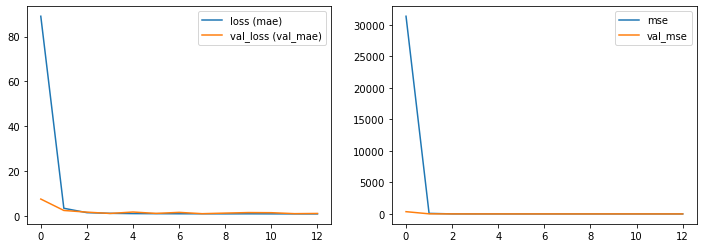

In [14]:
# lets take only phase fraction first
if __name__ == "__main__":
    
    y_train_pp = y_train[:,:n_ph]
    y_val_pp = y_val[:,:n_ph]
    
    # =============================================================================
    #     Build a model from NNmodels.py
    # =============================================================================
    model_pp = DNN_model(  
                        len(X_train[0]),
                        layer_activation="tanh",
                        output_activation="relu",
                        dropout=0,
                        DNN_layers=1,
                        DNN_filters=[len(X_train[0]), len(X_train[0])//2, len(X_train[0])//3],
                        output_neurons=n_ph,
                        learning_rate=0.001,
                        optimizer="adam",
                        loss= "mae")
    # model.summary()
    
    ## some callback functions to stop and save model
    es_pp = EarlyStopping(monitor='val_loss', mode='min', patience=5)
    ms_pp = ModelCheckpoint("best_val_loss_model_pp.h5", monitor='val_loss', 
                         mode='min', save_best_only=True)
    
    # =============================================================================
    #     Hyperparameters definition for training
    # =============================================================================
    start = time.time()
    history = model_pp.fit(X_train,
                        y_train_pp,
                        epochs          = 20,
                        batch_size      = 256,
                        verbose         = 1,
                        validation_data = (X_val, y_val_pp),
                        callbacks       = [es_pp, ms_pp])
    
    end = time.time()
    tps = int(end - start)
    print("Learning time: ", tps//60, 'minutes', tps%60, 'seconds')
    
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="loss (mae)")
    plt.plot(history.history['val_loss'], label="val_loss (val_mae)")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label="mse")
    plt.plot(history.history['val_mse'], label="val_mse")
    plt.legend()
    plt.show()
    
    # ## Step 6 : Evaluate
    # Model prediction on train dataset
    # y_predict = model.predict(X_val[:1,:])
    # y_predict = y_predict.astype(np.int64)
    # print("Ground Truth", y_val[0,:])
    # print("Prediction", y_predict[0, :])
    # print("Difference", sum(abs(y_predict[0, :] - y_val[0,:])))

2501/2501 [==============================] - 5s 2ms/step


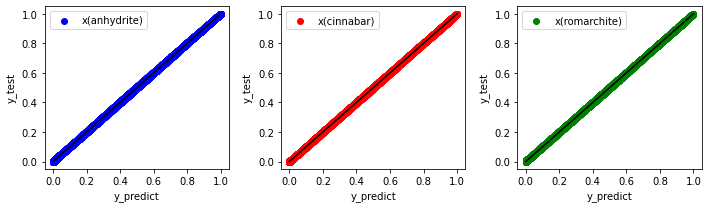

In [16]:
# Prediction of pp on val data
model_pp = load_model('best_val_loss_model_pp.h5')
y_predict_pp = model_pp.predict( X_val )

colors = ['b', 'r', 'g']
fig,axs = plt.subplots(1,3,figsize=(10,3))
for i in range(n_ph):
    axs = axs.flatten()
    axs[i].plot([0,1], [0,1], color="k")
    axs[i].scatter(y_predict_pp[:, i] / factor_multiplier_pp, 
                   y_val[:, i] / factor_multiplier_pp, 
                   color=colors[i],
                   label=f"x({dict_ph[i]})")
    axs[i].set_ylabel('y_test')
    axs[i].set_xlabel('y_predict')
    axs[i].legend()
plt.tight_layout()
plt.show()

Epoch 1/20
1251/1251 [==============================] - 15s 12ms/step - loss: 109.0158 - mse: 30164.3906 - mae: 109.0158 - val_loss: 72.5842 - val_mse: 15663.8477 - val_mae: 72.5842
Epoch 2/20
1251/1251 [==============================] - 14s 11ms/step - loss: 67.3379 - mse: 14543.0322 - mae: 67.3379 - val_loss: 73.6055 - val_mse: 15145.7197 - val_mae: 73.6055
Epoch 3/20
1251/1251 [==============================] - 14s 11ms/step - loss: 59.3727 - mse: 12357.3262 - mae: 59.3727 - val_loss: 56.6639 - val_mse: 11437.2891 - val_mae: 56.6639
Epoch 4/20
1251/1251 [==============================] - 14s 11ms/step - loss: 50.0162 - mse: 9857.6514 - mae: 50.0162 - val_loss: 49.1985 - val_mse: 9694.5801 - val_mae: 49.1985
Epoch 5/20
1251/1251 [==============================] - 14s 11ms/step - loss: 44.0238 - mse: 8139.2769 - mae: 44.0238 - val_loss: 46.5186 - val_mse: 8354.0361 - val_mae: 46.5186
Epoch 6/20
1251/1251 [==============================] - 14s 11ms/step - loss: 39.3241 - mse: 6841.3198

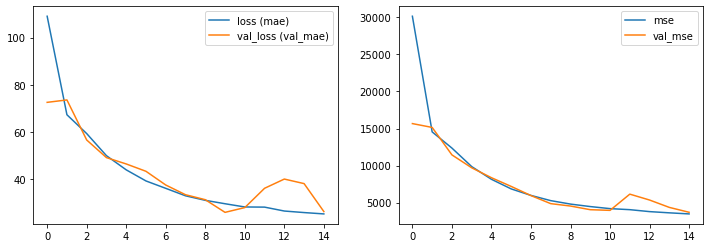

In [17]:
# Now let's take phase position
if __name__ == "__main__":
    
    y_train_h = y_train[:,n_ph:2*n_ph]
    y_val_h = y_val[:,n_ph:2*n_ph]
    
    # ## Step 4 : Build a model
    model_h = DNN_model(  
                        len(X_train[0]),
                        layer_activation="relu",
                        output_activation="relu",
                        dropout=0,
                        DNN_layers=1,
                        DNN_filters=[len(X_train[0]), len(X_train[0])//2, len(X_train[0])//3],
                        output_neurons=n_ph,
                        learning_rate=0.01,
                        optimizer="adam",
                        loss= "mae")
    # model.summary()
    
    ## some callback functions to stop and save model
    es_h = EarlyStopping(monitor='val_loss', mode='min', patience=5)
    ms_h = ModelCheckpoint("best_val_loss_model_h.h5", monitor='val_loss', 
                         mode='min', save_best_only=True)
    
    # ### Step 5 : Train it
    start = time.time()
    history = model_h.fit(X_train,
                        y_train_h,
                        epochs          = 20,
                        batch_size      = 256,
                        verbose         = 1,
                        validation_data = (X_val, y_val_h),
                        callbacks       = [es_h, ms_h])
    
    end = time.time()
    tps = int(end - start)
    print("Temps d'apprentissage : ", tps//60, 'minutes', tps%60, 'secondes')
    
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="loss (mae)")
    plt.plot(history.history['val_loss'], label="val_loss (val_mae)")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label="mse")
    plt.plot(history.history['val_mse'], label="val_mse")
    plt.legend()
    plt.show()
    
    # ## Step 6 : Evaluate
    # Model prediction on train dataset
    # y_predict = model.predict(X_val[:1,:])
    # y_predict = y_predict.astype(np.int64)
    # print("Ground Truth", y_val[0,:])
    # print("Prediction", y_predict[0, :])
    # print("Difference", sum(abs(y_predict[0, :] - y_val[0,:])))

2501/2501 [==============================] - 5s 2ms/step


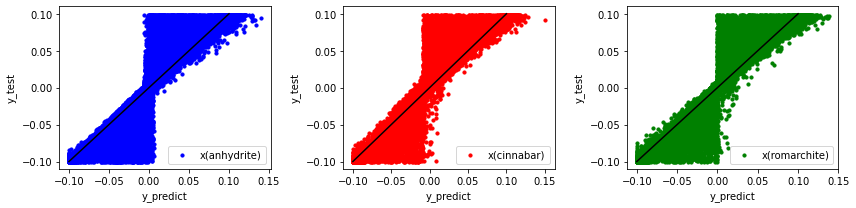

In [20]:
# Prediction of h on val data
model_h = load_model('best_val_loss_model_h.h5')
y_predict_h = model_h.predict( X_val )

colors = ['b', 'r', 'g']
fig,axs = plt.subplots(1,3,figsize=(12,3))
for i in range(n_ph):
    axs = axs.flatten()
    axs[i].plot([-0.1, 0.1], [-0.1, 0.1], color="k")
    axs[i].scatter(y_predict_h[:, i] / factor_multiplier_h - 0.1, 
                   y_val[:, n_ph+i] / factor_multiplier_h - 0.1, 
                   color=colors[i],
                   s=10,
                   label=f"x({dict_ph[i]})")
    axs[i].set_ylabel('y_test')
    axs[i].set_xlabel('y_predict')
    axs[i].legend()

plt.tight_layout()
plt.show()

## Prediction on experimental data

In [4]:
file = h5py.File('rep-6_layer_0_0002_powder_short-iback_clean_corr_new.h5', 'r')
print(f"Dataset keys: {file.keys()}")

# Load the real data to work on
real_data_Rep6 = np.array(file['data/data'])
# Extract the number of translation and rotation
t = real_data_Rep6.shape[0]
r = real_data_Rep6.shape[1]

# Real data are shaped as a 2D array instead of 3D for ease of use (in some cases)
real_data_Rep6_reshaped = real_data_Rep6.reshape(r*t, real_data_Rep6.shape[2])

print(f"\nExperimental dataset shape: {real_data_Rep6.shape}")
theta = np.array(file['data/theta']) # Extract theta range from h5 file

# Here, some other specs
mask = np.array(file['recons/mask'])
cont = np.array(file['recons/contour'])

Dataset keys: <KeysViewHDF5 ['2theta', 'data', 'recons']>

Experimental dataset shape: (25, 360, 2000)


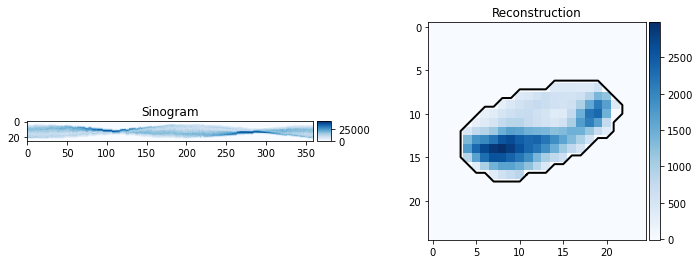

In [5]:
# Plot of sinograms and reconstruction
fig = plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
im1 = plt.imshow(np.sum(real_data_Rep6, 2), cmap='Blues', aspect='equal')
plt.title("Sinogram")
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)


plt.subplot(1, 2, 2)
recons=iradon(np.sum(real_data_Rep6, 2), theta=theta, circle=True, interpolation='linear', filter_name='cosine')
im2 = plt.imshow(recons*mask, cmap='Blues', interpolation='none')
plt.plot(cont[:, 1], cont[:, 0], linewidth=2, color='black')
plt.title("Reconstruction")
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

In [6]:
# =============================================================================
#     Normalisation before prediction with NN
# =============================================================================
# Keep scale factors for total semi-quanti afterwards
scale_factors = np.zeros((real_data_Rep6_reshaped.shape[0], 1))

for i in range(real_data_Rep6_reshaped.shape[0]):
    rowmax = np.max(real_data_Rep6_reshaped[i])
    scale_factors[i,0] = rowmax
    if rowmax == 0:
        continue # avoid calculations where there is no pattern i.e. "outside" the sinogram
    else:
        real_data_Rep6_reshaped[i] = real_data_Rep6_reshaped[i] / rowmax

In [7]:
# =============================================================================
#     Predictions on real data
# =============================================================================
start = time.time()

model_pp = load_model('best_val_loss_model_pp_mockup_rep6.h5')
model_h = load_model('best_val_loss_model_h_mockup_rep6.h5')

Rep6_pp = model_pp.predict(real_data_Rep6_reshaped)
Rep6_h = model_h.predict(real_data_Rep6_reshaped) 

end = time.time()

print(f'Prediction time: {int(end-start)//60} minutes {int(end-start)%60} seconds')

# Prediction outputs need to be divided by their multiplier factors (and offset for h)
Rep6_pp = Rep6_pp / factor_multiplier_pp
Rep6_h = Rep6_h / factor_multiplier_h - 0.1

# Delete the prediction that can be made on null patterns
Rep6_pp[np.sum(real_data_Rep6_reshaped, axis=1) == 0, :] = 0

# In every pixel of the sinogram: sum of phase fractions == 1
for i in range(Rep6_pp.shape[0]):
    tot = np.sum(Rep6_pp[i,:])
    if tot == 0:
        continue
    else:
        for j in range(Rep6_pp.shape[1]):
            Rep6_pp[i,j] = Rep6_pp[i,j] / tot
        
# All pixel is scaled by its scale factor from previous normalisation
Rep6_pp_scaled = Rep6_pp * scale_factors
Rep6_pp_scaled = Rep6_pp_scaled.reshape(t, r, len(dict_ph))

# The dataset is reshaped as 3D array like h5
Rep6_pp = Rep6_pp.reshape(t, r, len(dict_ph))
Rep6_h = Rep6_h.reshape(t, r, len(dict_ph))

# display S-Q calculations
for i in range (len(dict_ph)):
    print(f"{dict_ph[i]}: {np.round(100 * sum(sum(Rep6_pp_scaled[:,:,i])) / sum(sum(sum(Rep6_pp_scaled))), 1)}%")

282/282 [==============================] - 1s 2ms/step
Prediction time: 0 minutes 1 seconds
anhydrite: 93.1%
cinnabar: 4.0%
romarchite: 2.9%


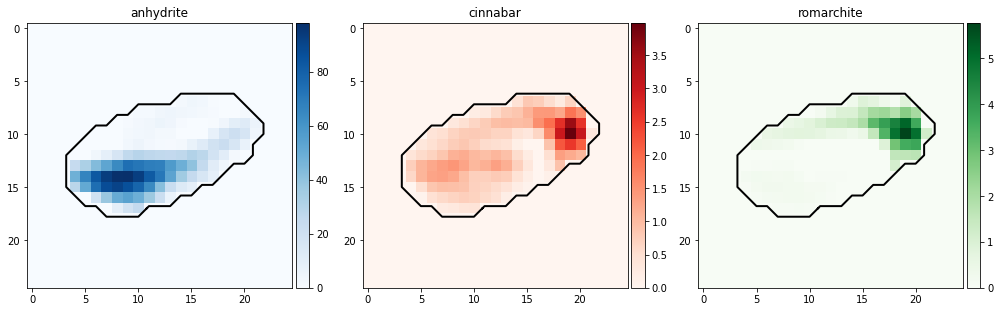

In [8]:
# Plot of the phases fractions maps for each phase as reconstructions
recons_pp_tot = np.empty((t, t, 0), float)

for i in range(len(dict_ph)):    
    recons_pp = mask * iradon(Rep6_pp_scaled[:, :, i], theta=theta, circle=True, interpolation='linear', filter_name='cosine')
    recons_pp[recons_pp<0] = 0
    recons_pp = recons_pp.reshape(t, t, 1)
    recons_pp_tot = np.append(recons_pp_tot, recons_pp, axis=2)

fig = plt.figure(figsize=(14,8))

cmap_color = ['Blues', 'Reds', 'Greens']

for i in range(len(dict_ph)):    
    plt.subplot(1, 3, i+1)
    im = plt.imshow(recons_pp_tot[:, :, i], cmap=cmap_color[i], interpolation='none')
    plt.plot(cont[:, 1], cont[:, 0], linewidth=2, color='black')
    
    plt.title(f"{dict_ph[i]}")
    
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()

In [9]:
# Data coming from serial refinement
datasetRep6_top_name = 'REP6_seq_topas.h5'
file = h5py.File(datasetRep6_top_name, 'r')
print(f"Dataset keys: {file.keys()}")


# Load tth from hp5
dataset_Rep6_top = np.array(file['data/data_scale'])
print(f"\nExperimental dataset shape: {dataset_Rep6_top.shape}")
theta_top = np.array(file['data/theta'])
mask_top = np.array(file['recons/mask'])
cont_top = np.array(file['recons/contour'])

t = dataset_Rep6_top.shape[0]
r = dataset_Rep6_top.shape[1]

Dataset keys: <KeysViewHDF5 ['data', 'recons']>

Experimental dataset shape: (25, 360, 3)


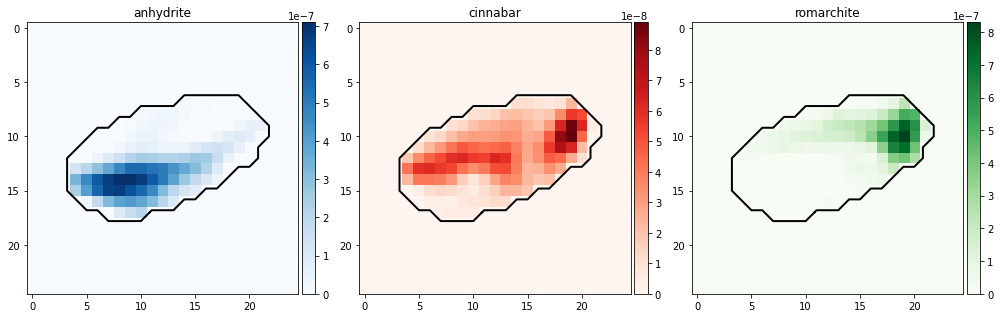

In [10]:
# Plot of the phases fractions maps for each phase as reconstructions
recons_pp_tot_top = np.empty((t, t, 0), float)

for i in range(len(dict_ph)):    
    recons_pp_top = mask_top * iradon(dataset_Rep6_top[:, :, i], theta=theta, circle=True, interpolation='linear', filter_name='cosine')
    recons_pp_top[recons_pp_top<0] = 0
    recons_pp_top = recons_pp_top.reshape(t, t, 1)
    recons_pp_tot_top = np.append(recons_pp_tot_top, recons_pp_top, axis=2)

fig = plt.figure(figsize=(14,8))
    
for i in range(len(dict_ph)):    
    plt.subplot(1, 3, i+1)
    im = plt.imshow(recons_pp_tot_top[:, :, i], cmap=cmap_color[i], interpolation='none')
    plt.plot(cont_top[:, 1], cont_top[:, 0], linewidth=2, color='black')
    
    plt.title(f"{dict_ph[i]}")
    
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.tight_layout()

## Rebuilding the patterns from pp and h predictions

In [11]:
if __name__ == "__main__":
    
    y_predict_pp = Rep6_pp.reshape(r*t, n_ph)
    y_predict_h = Rep6_h.reshape(r*t, n_ph)
    
    n_processes = cpu_count()
    print("Starting drx pattern regeneration on "+str(n_processes)+" CPUs")
    start = time.time()
    
    args = zip(itertools.repeat(list_tth), itertools.repeat(list_db), 
                itertools.repeat(list_icor), y_predict_pp, y_predict_h)
    with Pool(processes=n_processes) as proc_pool:
        results = proc_pool.starmap(MP_Pattern_rebuilding, tqdm(args, total=len(y_predict_pp)))
            
    # =============================================================================
    #     Concatenate the results to form one numpy array
    # =============================================================================
    dataset_rebuilt = np.empty((0, length_list), float)
    for res in results:
        dataset_rebuilt = np.append(dataset_rebuilt, res, axis=0)

    # =============================================================================
    #     Writing the dataset into a pickle file
    # =============================================================================        
    with open("patterns_rebuilt_test.pickle", "wb") as output_file:
        cPickle.dump([dataset_rebuilt], output_file)
        
    print("Shape du dataset :", dataset_rebuilt.shape)
    
    # Print the creation time of the dataset
    end = time.time()
    tps = int(end - start)
    print("Temps : ", tps//60, 'minutes', tps%60, 'secondes')
    # Print the number of error in the dataset
    print("Nombre d'erreur :", np.isnan(dataset_rebuilt).sum())

Starting drx pattern regeneration on 40 CPUs


100%|██████████| 9000/9000 [00:01<00:00, 5201.16it/s] 


Shape du dataset : (9000, 2000)
Temps :  4 minutes 11 secondes
Nombre d'erreur : 0


In [12]:
with open("mockup_rep6_rebuilt.pickle", "rb") as input_file:
    dataset_rebuilt = cPickle.load(input_file)[0]

Rwp_reshaped = []

for i in range(real_data_Rep6_reshaped.shape[0]):
    if sum(real_data_Rep6_reshaped[i,:]) < 1e-12:
        Rwp_reshaped = np.append(Rwp_reshaped, [0], axis=0)
    else:
        rwp = Rwp(real_data_Rep6_reshaped[i,:], dataset_rebuilt[i,:])
        Rwp_reshaped = np.append(Rwp_reshaped, [rwp], axis=0)

print(f"Moyenne du Rwp :{np.mean(Rwp_reshaped)}")

Moyenne du Rwp :52.04376364030049


Number of outliers of Rwp above 200: 2


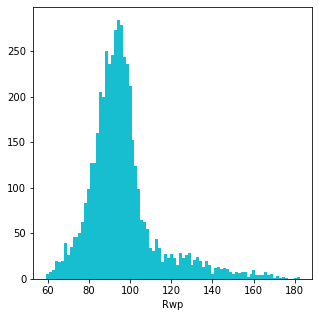

In [15]:
max_hist = 200
Rwp_RR = Rwp_reshaped[(Rwp_reshaped>0) & (Rwp_reshaped<max_hist)]
print(f"Number of outliers of Rwp above {max_hist}: {np.array(np.where((Rwp_reshaped>max_hist))).shape[1]}")

plt.close()
plot = plt.figure(figsize=(5, 5))
plt.hist(Rwp_RR, bins=86, color='tab:cyan')
plt.xlabel('Rwp')
# plot.savefig('histo_rwp_rep6_new.png', bbox_inches='tight', dpi=1200)
plt.show()